## Webpage Classification 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from itertools import product
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from matplotlib.colors import ListedColormap
% matplotlib inline

In [5]:
sns.set(font_scale = 1.2, style = "whitegrid")
# set plotting config for seaborn

In [6]:
lemma = WordNetLemmatizer()
# initialize object for lemmatization

### Load data 

In [7]:
df = pd.read_csv(filepath_or_buffer = "data.csv")
# load the data from the file

In [8]:
df.dropna(how = "any", inplace = True)
# drop NA's

In [9]:
df.head(n = 10)

,URL,Text,University,Label
0,http_^^cs.cornell.edu^Info^Courses^Current^CS4...,computer science home page computer science sy...,cornell,course
1,http_^^cs.cornell.edu^Info^Courses^Fall-95^CS4...,computer science home page computer science sy...,cornell,course
2,http_^^cs.cornell.edu^Info^Courses^Spring-96^C...,computer science home page computer science da...,cornell,course
3,http_^^simon.cs.cornell.edu^Info^Courses^Curre...,computer science home page computer science ho...,cornell,course
4,http_^^simon.cs.cornell.edu^Info^Courses^Sprin...,computer science computer science practicum di...,cornell,course
5,http_^^www.cs.cornell.edu^Info^Courses^Current...,computer science homepage fall running netscap...,cornell,course
6,http_^^www.cs.cornell.edu^Info^Courses^Current...,computer scienceb fall home page computer scie...,cornell,course
7,http_^^www.cs.cornell.edu^Info^Courses^Current...,computer science fall home page computer scien...,cornell,course
8,http_^^www.cs.cornell.edu^Info^Courses^Current...,computer science home page computer science st...,cornell,course
9,http_^^www.cs.cornell.edu^Info^Courses^Current...,computer science computer science fall course ...,cornell,course


## Pre-processing 

In [10]:
def add_url_to_text(data):
    """
    This function helps to add key words
    from the URL to the text for final
    analysis.
    
    Arguments:
    
    1. data: Input row from the dataframe.
    
    Returns:
    
    1. data: Results with URL added.
    """
    
    data["URL"] = data["URL"].lower().replace(".html", "")
    # ignore HTML string
    data["URL"] = re.sub("[\d-]", "", data["URL"])
    # remove all digits from the text
    url_keys_lst = data["URL"].split("^")[3:]
    # get keywords from URL
    url_keys_lst = map(lambda x: lemma.lemmatize(x.decode("utf-8").replace("cs", "computer science")), url_keys_lst)
    # lemmatize the keywords
    data["Text"] = "{1} {0}".format(data["Text"], " ".join(url_keys_lst))
    # add keywords to text
    return data

In [11]:
df = df.apply(func = add_url_to_text, axis = 1)
# func call to add URL keywords

AttributeError: ("'str' object has no attribute 'decode'", 'occurred at index 0')

## Exploratory data analysis 

### Data distribution 

In [12]:
label_group_data = df.groupby(by = ["Label"]).agg("count").sort_values(by = "URL")
# group by class labels
univ_group_data = df.groupby(by = ["University"]).agg("count").sort_values(by = "URL")
# group by universities

In [13]:
def plot_data(df, x, y, title, xlabel = None, ylabel = None, angle = 0):
    """
    This function helps to visualize the data
    distribution.
    
    Arguments:
    
    1. df: The input pandas dataframe.
    2. x: The x-axis column name, or index.
    3. y: The y-axis column name, or index.
    4. title: The title of the plot.
    5. xlabel: The x-axis label, defaulted to None.
    6. ylabel: The y-axis label, defaulted to None.
    7. angle: The x-axis tick rotation.
    """
    
    plt.figure(figsize = (12, 6))
    sns.barplot(data = df, x = x, y = y, ci = None)
    plt.title(title, fontsize = 18)
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel(ylabel, fontsize = 15)
    plt.xticks(rotation = angle, fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show()

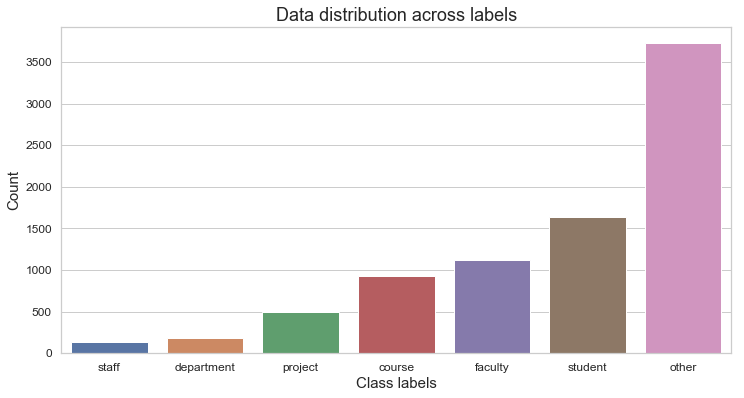

In [14]:
plot_data(label_group_data, x = label_group_data.index, y = "URL", title = "Data distribution across labels",
         xlabel = "Class labels", ylabel = "Count")

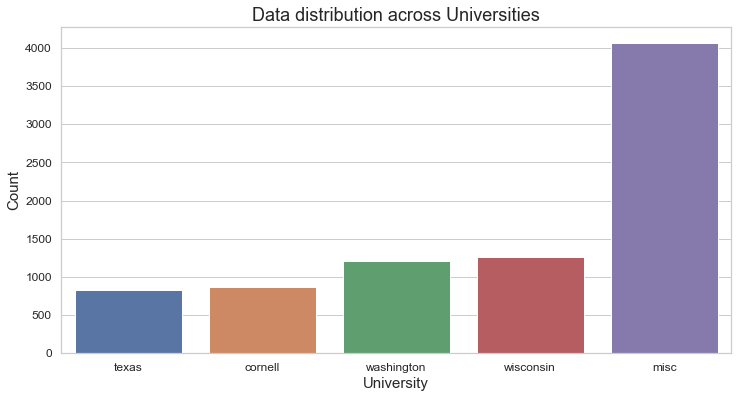

In [15]:
plot_data(univ_group_data, x = univ_group_data.index, y = "URL", title = "Data distribution across Universities",
         xlabel = "University", ylabel = "Count")

### Length analysis 

In [16]:
df["Length"] = df["Text"].apply(lambda x: len(x))
# get length of text

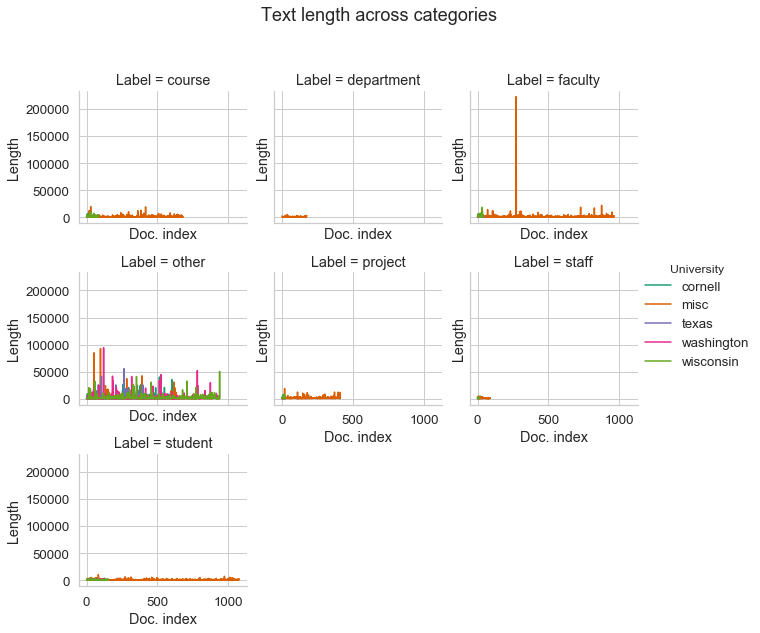

In [17]:
g = sns.FacetGrid(data = df, col = "Label", col_wrap = 3, hue = "University", palette = "Dark2")
# create facet plot
g = g.map(plt.plot, "Length").add_legend()
# plot data
g.set(xlabel = "Doc. index", ylabel = "Length")
# set axis labels
plt.suptitle("Text length across categories", fontsize = 18)
# plot title
plt.subplots_adjust(top=0.85)

### Adding bi-gram, and tri-gram to the data 

In [18]:
def add_n_grams(data, n):
    """
    This function helps to get the
    n-gram data from the input text.
    
    Arguments
    
    1. data: The input text data from which
    the n-gram is to be extracted.
    
    2. n: The "n" in n-gram.
    
    Returns
    
    1. The n-gram text data.
    """
    
    n_gram_str = ""
    # empty string
    data_ngram = nltk.ngrams(data.split(), n = n)
    # generate n-grams
    data_ngram = ["_".join(gram) for gram in data_ngram]
    # iterate over each n-gram
    return " ".join(data_ngram)

In [19]:
df["bigram_text"] = df["Text"].apply(lambda x: add_n_grams(x, 2))
# get bi-gram data

In [20]:
df["trigram_text"] = df["Text"].apply(lambda x: add_n_grams(x, 3))
# get tri-gram data

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: generator 'ngrams' raised StopIteration


###  Frequency analysis

In [21]:
def frequency_charts(df, wordcloud = False, top = 10, title = None):
    """
    This function helps to perform frequency
    analysis on the data.
    
    Arguments:
    
    1. df: The input pandas dataframe.
    2. wordcloud: If True, plots a wordcloud map, apart
    from the common word plot.
    3. top: The top "N" words to be plotted, default to 10.
    4. title: The title of plot, defaulted to None.
    """
    
    word_tokens = []
    # empty list for word tokens
    for sentence in df:
        # iterate over each sentence
        word_tokens.extend(sentence.split())
        # add work tokens
    text_nltk = nltk.Text(word_tokens)
    # generate nltk text
    text_freq = nltk.FreqDist(text_nltk)
    # get text frequency
    
    top_words = text_freq.most_common(n = top)
    words_tuple, frequeny_tuple = zip(*top_words)
    # words, and their frequency
    plot_data(df = None, x = list(words_tuple), y = list(frequeny_tuple), xlabel = "Words",
             ylabel = "Count", title = title, angle = 60)
    
    if wordcloud:
        # generate word cloud
        wordcloud = WordCloud().generate(" ".join(word_tokens))
        plt.figure(figsize = (12, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

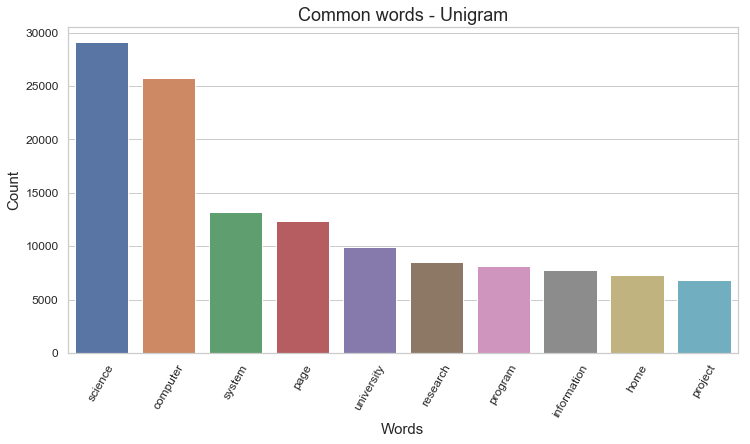

In [22]:
frequency_charts(df["Text"], title = "Common words - Unigram")

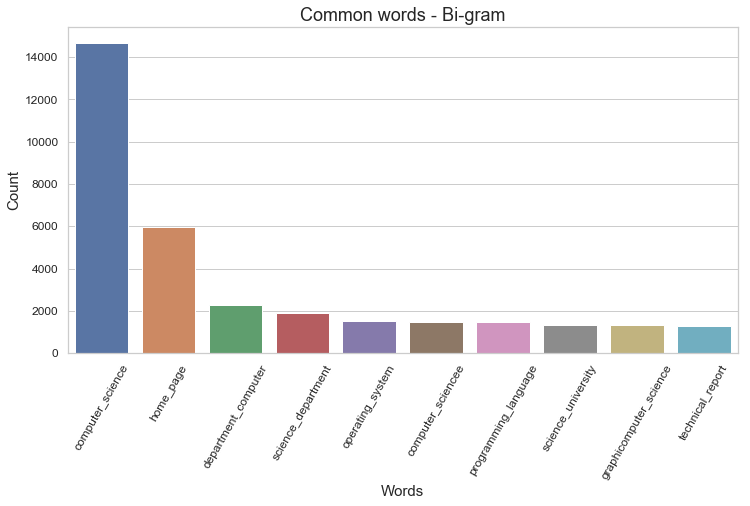

In [23]:
frequency_charts(df["bigram_text"], title = "Common words - Bi-gram")

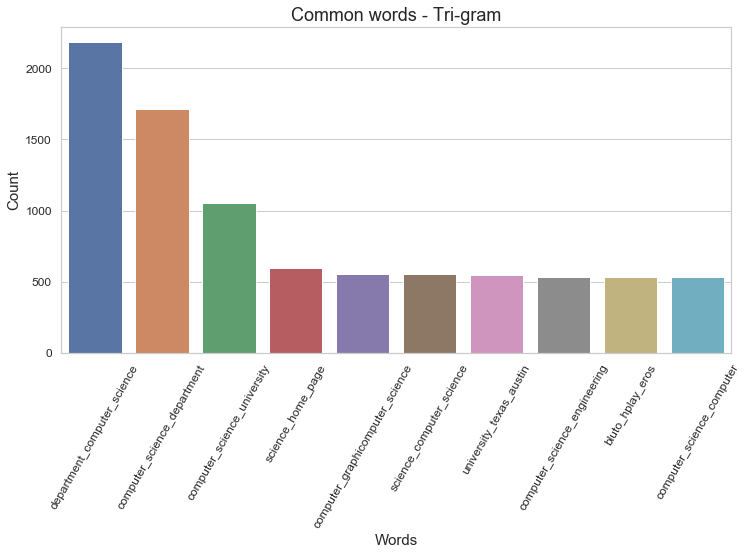

In [24]:
frequency_charts(df["trigram_text"], title = "Common words - Tri-gram")

In [25]:
df["features"] = df[['Text', 'bigram_text']].apply(lambda x: ' '.join(x), axis=1)
# get the feature set for the model

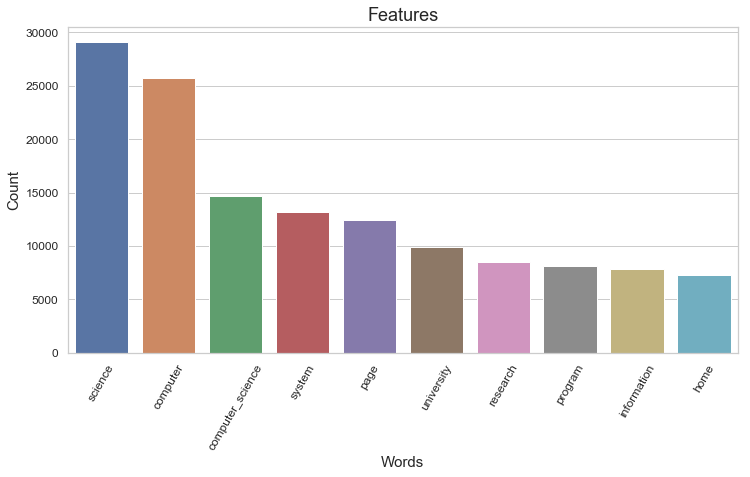

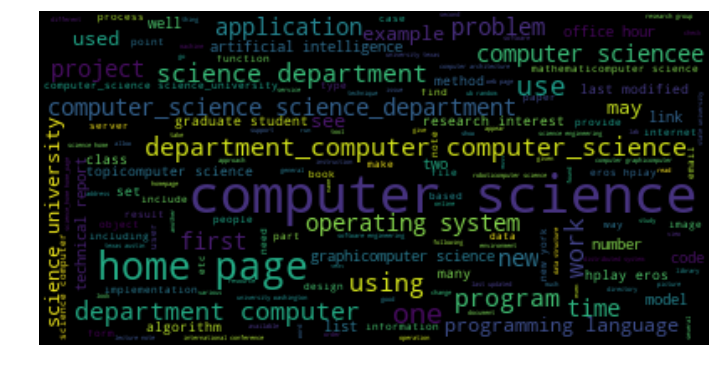

In [26]:
frequency_charts(df["features"], title = "Features", wordcloud = True)

### Train and test 

In [27]:
from sklearn.preprocessing import LabelEncoder

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
df["Label"] = LabelEncoder().fit_transform(df["Label"])
# encode text labels to numbers

In [ ]:
test = df[df["University"] == "wisconsin"]
# test data
train = df.drop(test.index)
# train data

In [ ]:
train_X, train_y, test_X, test_y = train["features"], train["Label"].values, test["features"], test["Label"].values

### Feature extraction  - TF-IDF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, validation_curve, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

In [ ]:
def feature_extraction_and_scaling(train_x, test_x):
    """
    This function helps to perform 
    feature extraction, and scale the data.
    
    Arguments:
    
    1. train_x: The train data.
    
    2. test_x: The test data.
    
    Return:
    
    1. Refined data set.
    """
    
    count_vect = CountVectorizer()
    # initialize count vectors
    tfidf = TfidfTransformer()
    # initialize tf-idf transformer
    train_x = count_vect.fit_transform(train_x)
    # fit count vector to data
    train_x = tfidf.fit_transform(train_x)
    # tf-idf on train data
    test_x = count_vect.transform(test_x)
    test_x = tfidf.transform(test_x)
    # transform the test data
    scaler = preprocessing.StandardScaler(with_mean = False).fit(train_x)
    # scaling of data
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)
    return train_x, test_x

In [ ]:
train_X, test_X = feature_extraction_and_scaling(train_X, test_X)
# feature extraction and scaling

## Feature selection 

In [ ]:
n_est_lst = range(25, 101, 25)
# number of estimators for random forest

In [ ]:
k_lst = [500, 1000, 2000, 5000, 10000, 100000, 200000, train_X.shape[1]]
# number of features to be tried

In [ ]:
def plot_data_2(df, n_est_lst):
    """
    This function plots the metrics data
    with the various parameters used for tuning
    using cross validation.
    
    Arguments:
    
    1. df: The input dataframe for plotting.
    2. n_est_lst: The estimator parameter used for random forest.
    """

    fig, ax = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (15, 7))
    ax = ax.flatten()
    # generate subplots
    for i in range(len(n_est_lst)):
        # iterate over each estimator value
        data = df[df["n_estimators"] == n_est_lst[i]].sort_values(by = "k")
        ax[i].plot(data["k"], data["f1"], "r--")
        ax[i].set_title("Num of estimators: " + str(n_est_lst[i]), fontsize = 12)
        ax[i].set_xlabel("Features used", fontsize = 12)
        ax[i].set_ylabel("f1", fontsize = 12)
    plt.tight_layout()
    plt.suptitle("f1-score Vs Number of features for various estimator values", fontsize = 15, y = 1.02)
    plt.show()

In [ ]:
def plot_model_selection(function):
    """
    This function follows the model selection process.
    From the CV results, plots the metric values for
    all parameters used.
    
    Argument:
    
    1. function: In this case, it's "model_selection_process func" 
    """

    def wrapper(*args, **kwargs):
        """
        Wrapper function
        """

        clf = function(*args, **kwargs)
        # model selection classifier
        cv_results, results_dict = clf.cv_results_, {}
        # CV results and dict
        for i in range(len(cv_results["params"])):
            # iterate over index of parameter
            key = tuple(cv_results["params"][i].items())
            # key to the dictionary
            results_dict[key] = []
            # create keys
            for j in range(kwargs["num_splits"]):
                # iterate over each split
                score = cv_results["split{0}_test_score".format(j)][i]
                results_dict[key].append(score)
                # add score result
            results_dict[key] = np.mean(results_dict[key])
            # take mean of results
        df = pd.DataFrame()
        # empty dataframe
        val = zip(*results_dict.items())[0]
        df["k"] = zip(*zip(*val)[0])[1]
        df["n_estimators"] = zip(*zip(*val)[1])[1]
        df["f1"] = results_dict.values()
        # add values to dataframe
        plot_data_2(df, kwargs["n_est_lst"])
        # func call to plot
        return clf
    
    return wrapper      

In [ ]:
@plot_model_selection
def model_selection_process(train_x, train_y, k_lst, n_est_lst, num_splits = 3):
    """
    This function helps to perform the 
    model selection process using cross validation.
    
    Arguments:
    
    1. train_x: The input features.
    2. train_y: The output class label.
    3. k_lst: The various number of features to be tried.
    4. n_est_lst: The number of estimators to be tried for random forest.
    
    Returns:
    
    1. The classifier model built.
    """
    
    cv = StratifiedShuffleSplit(n_splits = num_splits, test_size = 0.1, random_state = 0)
    # define how data is to be splitted for cross validation
    top_k = SelectKBest(score_func = f_classif, k = 1)
    # method to get the top-k features using chi2 test
    pipe = Pipeline([("topk", top_k), ("rforest", RandomForestClassifier())])
    # pipeline defining work flow
    params = {"topk__k":k_lst, "rforest__n_estimators":n_est_lst}
    # parameters to be tested for model selection
    clf = GridSearchCV(pipe, param_grid = params, n_jobs = -1, cv = cv, scoring = "f1_weighted")
    # model selection process
    clf.fit(train_x, train_y)
    # fit the data
    return clf

In [ ]:
clf = model_selection_process(train_x = train_X, train_y = train_y, k_lst = k_lst,
                             n_est_lst = n_est_lst, num_splits = 3)

In [ ]:
print("Best Parameters")
print(clf.best_params_)

### Final feature set

In [ ]:
top_k_clf = SelectKBest(score_func = f_classif, k = clf.best_params_["topk__k"])
# selecting top K features
train_X = top_k_clf.fit_transform(train_X, train_y)
# fit the data

In [ ]:
test_X = top_k_clf.transform(test_X)

### Validation scores

In [ ]:
param_lst = [25, 50, 75, 100, 125, 150, 175, 200]
# various parameter values

In [ ]:
cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.1, random_state = 0)
# define how data is to be splitted for cross validation

In [ ]:
train_scores, test_scores = validation_curve(RandomForestClassifier(), train_X, train_y, 
                                            param_name = "n_estimators", param_range  = param_lst,
                                            scoring = "f1_weighted", n_jobs = -1, cv = cv)
# get the validation results for the decision tree across various depths

In [ ]:
train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)
plt.figure(figsize = (15, 7))
plt.plot(param_lst, train_score_mean, label = "Training scores")
plt.plot(param_lst, test_score_mean, label = "Cross Validation scores")
plt.fill_between(param_lst, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(param_lst, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Validation curve of Random forest classifier with varying N-estimators")
plt.xlabel("Number of estimators")
plt.ylabel("f1-score")

### Learning curve 

In [ ]:
size = np.linspace(0.1, 1, 10)
# the size of train sets
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(clf.best_params_["rforest__n_estimators"]),
                                                        X = train_X, y = train_y,
                                                        cv = cv, n_jobs = -1, train_sizes = size)
# get the learning curve results for the data

Text(0,0.5,u'f1-score')

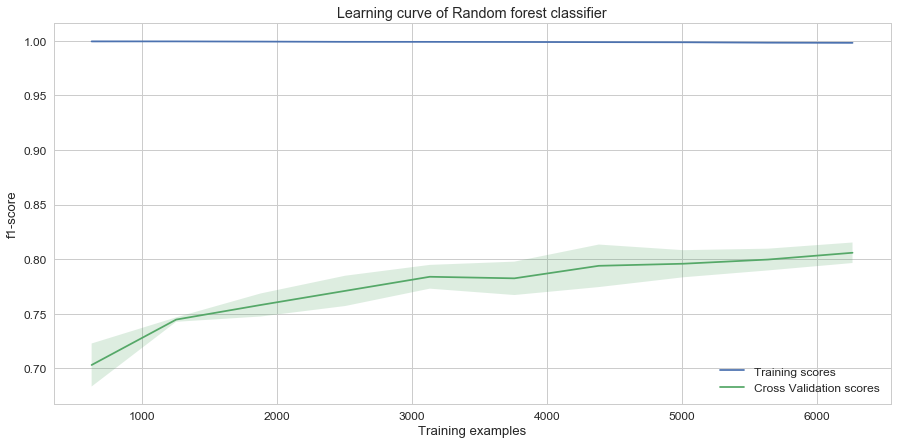

In [49]:
train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)
plt.figure(figsize = (15, 7))
plt.plot(train_sizes, train_score_mean, label = "Training scores")
plt.plot(train_sizes, test_score_mean, label = "Cross Validation scores")
plt.fill_between(train_sizes, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(train_sizes, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Learning curve of Random forest classifier")
plt.xlabel("Training examples")
plt.ylabel("f1-score")

### Bias- variance trade off 

In [50]:
n_samples = 250
# no of samples
iterations = 250
# no of iterations
depth_values = range(1, 30, 5)

In [51]:
bias_final, variance_final = [], []
# lists to store the bias and variance values

In [52]:
for depth in depth_values:
    # iterate over each depth value
    bias_var_df = pd.DataFrame()
    for i in range(iterations):
        # iterations
        random_index = np.random.choice(train_X.shape[0], size = n_samples)
        X_sample = train_X[random_index]
        y_sample = train_y[random_index]
        # generate random data
        classifier = RandomForestClassifier(n_estimators = clf.best_params_["rforest__n_estimators"],
                                     max_depth = depth)
        # develop the decision tree classifier
        classifier.fit(X_sample, y_sample)
        # fit data to model
        pred = classifier.predict(test_X)
        # get the predicted values
        bias_var_df[str(i + 1)] = pred
        # add predicted to dataframe
    
    average_pred = bias_var_df.mean(axis = 1)
    average_pred = ((test_y - average_pred)**2).mean()
    bias_final.append(average_pred)
    # get the average prediction for given depth
    average_var = bias_var_df.var(axis = 1).mean()
    variance_final.append(average_var)
    # average variance for given depth
    

Text(0.5,1,u'Bias-Variance trade off Vs Depth (Random forest classifier)')

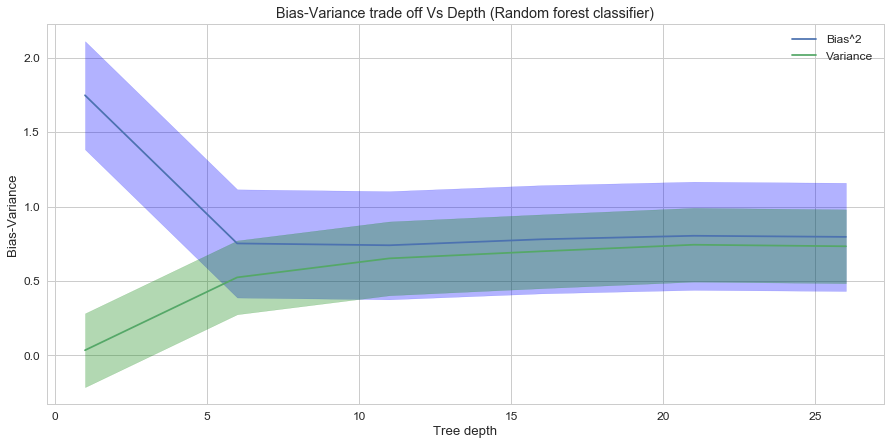

In [53]:
plt.figure(figsize = (15, 7))
plt.plot(depth_values, bias_final, label = "Bias^2")
plt.fill_between(depth_values, bias_final - np.std(bias_final),
                     bias_final + np.std(bias_final), alpha=0.3, color="b")
plt.plot(depth_values, variance_final, label = "Variance")
plt.fill_between(depth_values, variance_final - np.std(variance_final),
                     variance_final + np.std(variance_final), alpha=0.3, color="g")
plt.legend(loc = "best")
plt.xlabel("Tree depth")
plt.ylabel("Bias-Variance")
plt.title("Bias-Variance trade off Vs Depth (Random forest classifier)")

### Final machine learning model 

#### Adding lengths as a feature 

In [54]:
train_lenghts = train["Length"].values.reshape(len(train["Length"]), 1)
test_lengths = test["Length"].values.reshape(len(test["Length"]), 1)

In [55]:
train_X = np.hstack((train_X.toarray(), train_lenghts))
test_X = np.hstack((test_X.toarray(), test_lengths))
# adding the length of the document as a feature

In [56]:
best_clf = RandomForestClassifier(n_estimators = clf.best_params_["rforest__n_estimators"],
                                 max_depth = 5)
# final random forest model
best_clf.fit(train_X, train_y)
# fit data to classifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Make predictions on test data 

In [57]:
predict = best_clf.predict(test_X)
# make prediction on test data

### Performance metrics

In [58]:
accuracy_score = metrics.accuracy_score(test_y, predict)
print "Accuracy score: {0}".format(round(accuracy_score, 3))

Accuracy score: 0.869


In [59]:
f1_score = metrics.f1_score(test_y, predict, average = "weighted")
print "F1-score: {0}".format(round(f1_score, 3))

F1-score: 0.85


C:\Users\c001384\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [60]:
print metrics.classification_report(test_y, predict)

             precision    recall  f1-score   support

          0       0.79      0.82      0.80        85
          1       0.00      0.00      0.00         1
          2       0.88      0.86      0.87        42
          3       0.88      0.96      0.92       941
          4       0.00      0.00      0.00        25
          5       0.00      0.00      0.00        12
          6       0.81      0.55      0.66       154

avg / total       0.84      0.87      0.85      1260



C:\Users\c001384\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


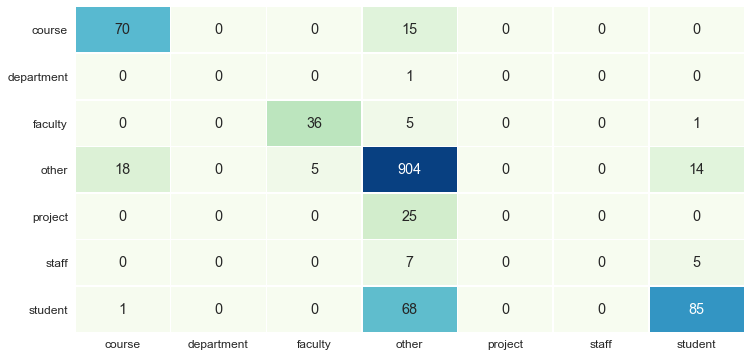

In [61]:
conf_mat = metrics.confusion_matrix(test_y, predict)
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = ["course", "department", "faculty", "other", "project", "staff", "student"]
conf_mat.index = conf_mat.columns
# get confusion matrix
plt.figure(figsize = (12, 6))
sns.heatmap(conf_mat, robust = True, annot = True, fmt="d", cbar = False, linewidths=.5, cmap="GnBu")

### Decision boundaries 

In [62]:
from sklearn.decomposition import PCA

In [63]:
pca = PCA(n_components = 2)
train_X_pca = pca.fit_transform(train_X)
test_X_pca = pca.transform(test_X)

clf_pca = RandomForestClassifier(n_estimators = clf.best_params_["rforest__n_estimators"], max_depth = 5)
clf_pca.fit(train_X_pca, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
colors_lst = ["salmon", "mistyrose", "linen", "lightgreen", "plum", "lightcyan", "thistle"]
# colors for each class label
label_map = dict(zip(range(7), ["course", "department", "faculty", "other", "project", "staff", "student"]))
# label, and their encoding

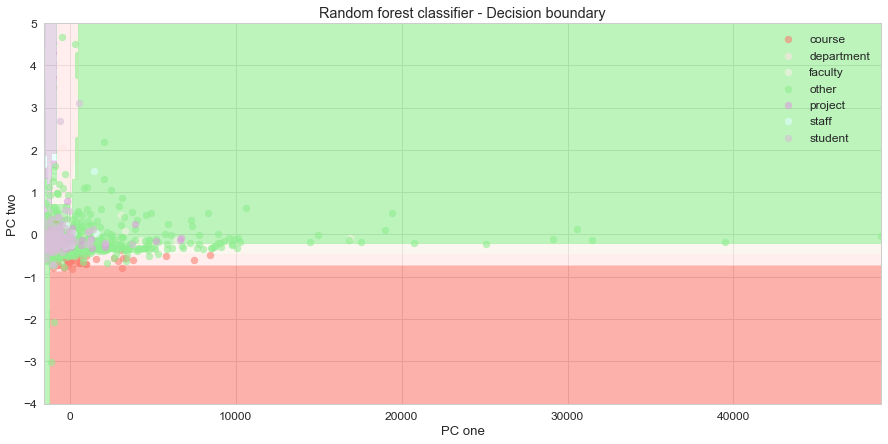

In [65]:
plt.figure(figsize = (15, 7))
X_set, y_set = test_X_pca, test_y

X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 1),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 1))
# create a grid of X-values in 2-dim space
plt.contourf(X1, X2, clf_pca.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.6, cmap = ListedColormap(colors_lst))
# create contours for labels
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
# set graph axis limits

for i, j in enumerate(np.unique(y_set)):
    # iterate over each class label
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(colors_lst)(i), label = label_map[j], alpha = 0.6)
    # plot the test data points on the graph
plt.title("Random forest classifier - Decision boundary")
plt.xlabel('PC one')
plt.ylabel('PC two')
plt.legend()
plt.show()